In [1]:
# https://www.kaggle.com/robertyoung/glove-twitter-pickles-27b-25d-50d-100d-200d?select=glove.twitter.27B.25d.pkl
# https://www.diycode.cc/projects/RaRe-Technologies/gensim-data
# https://github.com/hamelsmu/Seq2Seq_Tutorial/blob/master/notebooks/Tutorial.ipynb

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import re, string, unicodedata

from bs4 import BeautifulSoup
from helper.contractions import CONTRACTION_MAP
from helper.slangs import SLANGS_MAP

import inflect
import unidecode
import emoji

import spacy
from spacy.lang.en import English
from spacy.tokenizer import Tokenizer
from spacy.lemmatizer import Lemmatizer

from spacy.lookups import Lookups
lookups = Lookups()
lookups.add_table("lemma_rules", {"noun": [["s", ""]]})

from spellchecker import SpellChecker
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.tokenize import TweetTokenizer, TreebankWordTokenizer, WhitespaceTokenizer

from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

#from keras.preprocessing.text import text_to_word_sequence

# global variables
wtk = WhitespaceTokenizer()

In [3]:
# Word tokenization
from spacy.lang.en import English

# Load English tokenizer, tagger, parser, NER and word vectors
#nlp = English()
nlp = spacy.load('en_core_web_md')
#stopword_list = nltk.corpus.stopwords.words('english')
#nlp = spacy.load('en', disable=['parser', 'ner'])

def spacy_tokenization_lemma(text):
    text_nlp = nlp(text)
    token_list = []
    for token in text_nlp:
        #token_list.append(token.text)
        if token.lemma_ != '-PRON-':
            token_list.append(token.lemma_)
        
    return token_list

In [4]:
SLANGS_MAP.keys()

dict_keys(['AFAIK', 'AFK', 'ASAP', 'ATK', 'ATM', 'A3', 'BAK', 'BBL', 'BBS', 'BFN', 'B4N', 'BRB', 'BRT', 'BTW', 'B4', 'CU', 'CUL8R', 'CYA', 'FAQ', 'FC', 'FWIW', 'FYI', 'GAL', 'GG', 'GN', 'GMTA', 'GR8', 'G9', 'IC', 'ICQ', 'ILU', 'IMHO', 'IMO', 'IOW', 'IRL', 'KISS', 'LDR', 'LMAO', 'LOL', 'LTNS', 'L8R', 'MTE', 'M8', 'NRN', 'OIC', 'OMG', 'PITA', 'PRT', 'PRW', 'QPSA?', 'ROFL', 'ROFLOL', 'ROTFLMAO', 'SK8', 'STATS', 'ASL', 'THX', 'TTFN', 'TTYL', 'U', 'U2', 'U4E', 'WB', 'WTF', 'WTG', 'WUF', 'W8', '7K', '****', '*****', 'b****', 'b***h', '****,', '*****,', 'b****,', 'b***h,', '4U', '2U', 'FB', 'IG', 'LI', 'YT', 'TW'])

In [5]:
## Need to investiate the slangs specific to these tweet  category
# https://github.com/rishabhverma17/sms_slang_translator/blob/master/slang.txt

In [6]:
##-- handle punctuations
def _remove_punct(text): 
    punctuations = '''!()-[]{};:'"\,<>/?@#$%^&*_~'''
    for x in text.lower(): 
        if x in string.punctuation: 
            text = text.replace(x, "")
  
    return text


def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_words.append(_remove_punct(word))
        
    return new_words


# convert emojis
def convert_emoji(text):
    text = emoji.demojize(text)
    return text


# remove html tags
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

# remove URL from text
def remove_url(words):
    """Remove URLs from a sample string"""
    word_clean = []
    for word in words:
        text = re.sub(r"http\S+", "", word)
        if text:
            word_clean.append(text)
    return word_clean


### --- handle slangs
def unslang(text):
    """Convert slangs to corresponding english words"""
    wtk = WhitespaceTokenizer()
    words = wtk.tokenize(text)
    slangs = []
    for word in words:
        if word.upper() in SLANGS_MAP.keys():
            slangs.append(SLANGS_MAP[word.upper()])
        else:
            slangs.append(word)
            
    text_slangs = ' '.join(slangs)
    return text_slangs


def expand_contractions(text):
    wtk = WhitespaceTokenizer()
    words = wtk.tokenize(text)
    words_expand = []
    for word in words:
        if word in CONTRACTION_MAP.keys():
            words_expand.append(CONTRACTION_MAP[word])
        else:
            words_expand.append(word)
            
    text_expand = ' '.join(words_expand)
    return text_expand



##--- remove special characters
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text


# remove remianing non ascii characters
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words


### --- lemmatization
lemmatizer = Lemmatizer(lookups)
def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    #lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer(word)
        lemmas.append(lemma)
    return lemmas


###---- Remove stop words
def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words
   

def normalization(text):
    text = text.lower()
    text = convert_emoji(text)
    text = strip_html_tags(text)
    #text = remove_url(text)
    text = expand_contractions(text)
    text = unslang(text)
        
    # Tokenize
    words = spacy_tokenization_lemma(text)
    words = remove_url(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    
    words = ' '.join(words)
    words = words.strip().lower()
    
    return words


# normalize each document in the corpus
def normalize_corpus(corpus):
    
    normalized_corpus = []
    for doc in corpus:
        doc = normalization(doc.lower())
        normalized_corpus.append(doc)
        
    return normalized_corpus


In [7]:
spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)


In [8]:
train = pd.read_csv("data/train.csv", encoding='utf-8')
test = pd.read_csv("data/test.csv")
submission = pd.read_csv('data/sample_submission.csv')

In [9]:
train.dropna(axis=0, subset=('text', 'selected_text'), inplace=True)
test.dropna(axis=0, subset=('text', ), inplace=True)

In [10]:
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


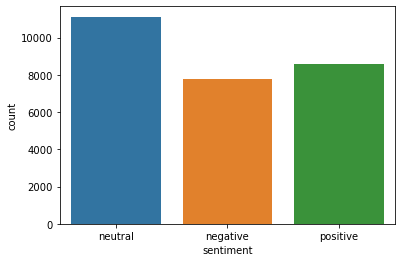

In [11]:
ax = sns.countplot(x="sentiment", data=train)

In [12]:
test.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


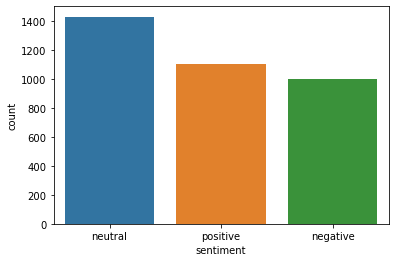

In [13]:
ax = sns.countplot(x="sentiment", data=test)

## Clean test  
1) use pycontaction inconjunction with gensim twitter pre-train model

In [14]:
%%time
train['text_norm'] = train['text'].apply(lambda x: normalization(x))

Wall time: 6min 9s


In [15]:
#%%time
train['selected_text_norm'] = train['selected_text'].apply(lambda x: normalization(x))

In [16]:
train.head()

,textID,text,selected_text,sentiment,text_norm,selected_text_norm
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,id have respond if i be go,id have respond if i be go
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,so sad i will miss here in san diego,so sad
2,088c60f138,my boss is bullying me...,bullying me,negative,boss be bully,bully
3,9642c003ef,what interview! leave me alone,leave me alone,negative,what interview leave alone,leave alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,son of fuck why couldnt put on the release alr...,son of fuck


In [17]:
%%time
test['text_norm'] = test['text'].apply(lambda x: normalization(x))

Wall time: 48.7 s


In [18]:
test.head()

,textID,text,sentiment,text_norm
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,last session of the day
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,shanghai be also really exciting precisely s...
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,recession hit veronique branquinho have to qu...
3,01082688c6,happy bday!,positive,happy birthday
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,i like


## EXPLORATORY DATA

### Number of words per tweet in train set

In [22]:
train['sentiment'].unique()

array(['neutral', 'negative', 'positive'], dtype=object)

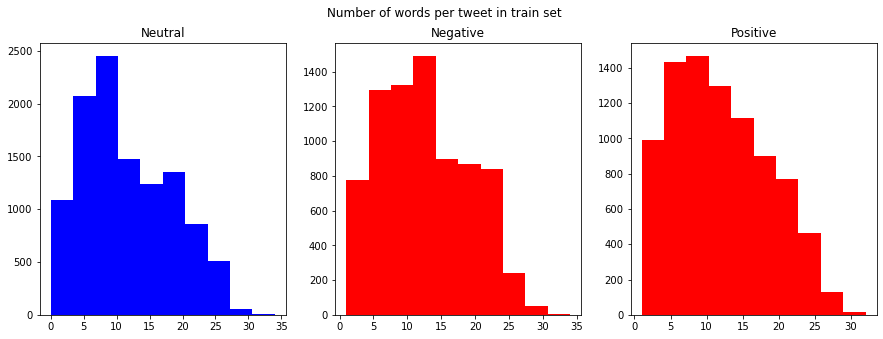

In [23]:
fig,(ax1,ax2, ax3) = plt.subplots(1,3,figsize=(15,5))

train_len = train[train['sentiment'] == 'neutral']['text_norm'].str.split().map(lambda x: len(x))
ax1.hist(train_len,color='blue')
ax1.set_title('Neutral')

train_len = train[train['sentiment'] == 'negative']['text_norm'].str.split().map(lambda x: len(x))
ax2.hist(train_len,color='red')
ax2.set_title('Negative')

train_len = train[train['sentiment'] == 'positive']['text_norm'].str.split().map(lambda x: len(x))
ax3.hist(train_len,color='red')
ax3.set_title('Positive')

fig.suptitle('Number of words per tweet in train set')
plt.show()

### Number of words per tweet in test set

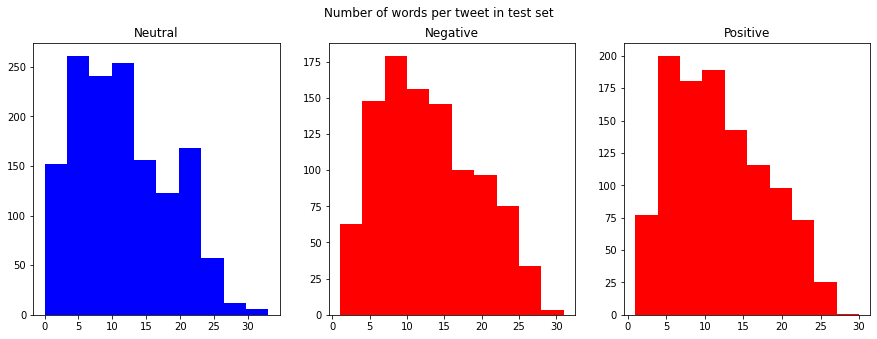

In [24]:
fig,(ax1,ax2, ax3) = plt.subplots(1,3,figsize=(15,5))

test_len = test[test['sentiment'] == 'neutral']['text_norm'].str.split().map(lambda x: len(x))
ax1.hist(test_len,color='blue')
ax1.set_title('Neutral')

test_len = test[test['sentiment'] == 'negative']['text_norm'].str.split().map(lambda x: len(x))
ax2.hist(test_len,color='red')
ax2.set_title('Negative')

test_len = test[test['sentiment'] == 'positive']['text_norm'].str.split().map(lambda x: len(x))
ax3.hist(test_len,color='red')
ax3.set_title('Positive')

fig.suptitle('Number of words per tweet in test set')
plt.show()

### Number of words per tweet in train selected text

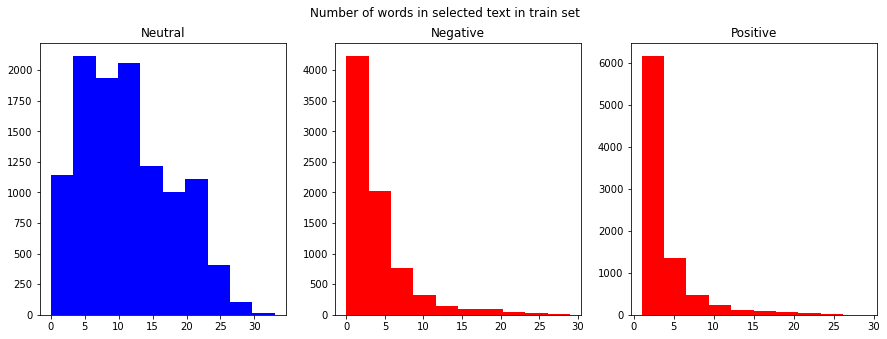

In [25]:
fig,(ax1,ax2, ax3) = plt.subplots(1,3,figsize=(15,5))

train_len = train[train['sentiment'] == 'neutral']['selected_text_norm'].str.split().map(lambda x: len(x))
ax1.hist(train_len,color='blue')
ax1.set_title('Neutral')

train_len = train[train['sentiment'] == 'negative']['selected_text_norm'].str.split().map(lambda x: len(x))
ax2.hist(train_len,color='red')
ax2.set_title('Negative')

train_len = train[train['sentiment'] == 'positive']['selected_text_norm'].str.split().map(lambda x: len(x))
ax3.hist(train_len,color='red')
ax3.set_title('Positive')

fig.suptitle('Number of words in selected text in train set')
plt.show()

In [52]:
train.dropna(axis=0, subset=['text_norm', 'selected_text_norm'], inplace=True)

In [ ]:
#test.dropna(axis=0, subset=['text_norm'], inplace=True)

## BERT

In [28]:
#!pip install transformers
# https://www.kaggle.com/parulpandey/eda-and-preprocessing-for-bert

In [29]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [31]:
# Tokenizing the first text
test_text = train['text_norm'][10]
print(test_text) # original sentence
print(tokenizer.tokenize(test_text, add_special_tokens=True))
print(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(test_text)))

as much as i love to be hopeful  i reckon the chance be minimal  p im never go to get cake and stuff
['as', 'much', 'as', 'i', 'love', 'to', 'be', 'hopeful', 'i', 'reckon', 'the', 'chance', 'be', 'minimal', 'p', 'im', 'never', 'go', 'to', 'get', 'cake', 'and', 'stuff']
[2004, 2172, 2004, 1045, 2293, 2000, 2022, 17772, 1045, 29072, 1996, 3382, 2022, 10124, 1052, 10047, 2196, 2175, 2000, 2131, 9850, 1998, 4933]


### Preprocessing data for Bert  
BERT expects input data in a specific format i.e  

1) Tokenized dataset.  
2) All the vectors should be of the same size.Hence,we need to pad the text to achieve a common length.This length will be decided by the length of longest sentence, which we will have to calculate.Also, since we shall concatanate the text and the sentiment column, the length should be decided by the concatanated text column.  
3) differentiate between the Actual tokens and the Padded ones with the help of "Attention Masks".


In [33]:
print(tokenizer.sep_token)
print(tokenizer.sep_token_id)
print(tokenizer.cls_token)
print(tokenizer.cls_token_id)

[SEP]
102
[CLS]
101


In [36]:
# calculating length of the longest text
max_len = 0
for text in train['text_norm']:

    # Tokenize the text and add special tokens i.e `[CLS]` and `[SEP]`
    input_ids = tokenizer.encode(text, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max length: ', max_len)

Max length:  46


In [37]:
max_len_sel = 0
for text in train['selected_text_norm']:

    # Tokenize the text and add special tokens i.e `[CLS]` and `[SEP]`
    input_ids = tokenizer.encode(text, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len_sel = max(max_len_sel, len(input_ids))

print('Max length: ', max_len_sel)

Max length:  46


## Pytorch

In [40]:
#!conda install --yes pytorch
# https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html


In [39]:
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [41]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [43]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [57]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    #lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').read().strip().split('\n')
    
    text = train['text_norm'].to_list()
    selected_text = train['selected_text_norm'].to_list()
    
    pairs = []
    for i in range(train.shape[0]):
        pairs.append([text[i], selected_text[i]])

    # Split every line into pairs and normalize
    #pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [53]:
MAX_LENGTH = 0
for text in train['text_norm']:
    MAX_LENGTH = max(max_len, len(text.split()))

print('Max length: ', MAX_LENGTH)

Max length:  46


In [ ]:
#MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

The full process for preparing the data is:

    Read text file and split into lines, split lines into pairs
    Normalize text, filter by length and content
    Make word lists from sentences in pairs


In [59]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    #pairs = filterPairs(pairs)
    #print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('text', 'sel_text', True)
print(random.choice(pairs))

Reading lines...
Read 27480 sentence pairs
Counting words...
Counted words:
sel_text 15329
text 22608
['make a mess', 'i chop a fringe in last night get tired of have hang in eye  make a mess']


In [60]:
input_lang

### The Encoder

In [46]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### The Decoder

In [47]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### Attention Decoder

In [51]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### Preparing Training Data

To train, for each pair we will need an input tensor (indexes of the words in the input sentence) and target tensor (indexes of the words in the target sentence). While creating these vectors we will append the EOS token to both sequences.

In [61]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

### Training the Model.  
To train we run the input sentence through the encoder, and keep track of every output and the latest hidden state. Then the decoder is given the <SOS> token as its first input, and the last hidden state of the encoder as its first hidden state.

“Teacher forcing” is the concept of using the real target outputs as each next input, instead of using the decoder’s guess as the next input. Using teacher forcing causes it to converge faster but when the trained network is exploited, it may exhibit instability.

You can observe outputs of teacher-forced networks that read with coherent grammar but wander far from the correct translation - intuitively it has learned to represent the output grammar and can “pick up” the meaning once the teacher tells it the first few words, but it has not properly learned how to create the sentence from the translation in the first place.

Because of the freedom PyTorch’s autograd gives us, we can randomly choose to use teacher forcing or not with a simple if statement. Turn teacher_forcing_ratio up to use more of it.

In [62]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, 
          criterion, max_length=MAX_LENGTH):
    
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [63]:
# This is a helper function to print time elapsed and estimated time remaining given the current time and progress %.
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The whole training process looks like this:

    Start a timer
    Initialize optimizers and criterion
    Create set of training pairs
    Start empty losses array for plotting

Then we call train many times and occasionally print the progress (% of examples, time so far, estimated time) and average loss.

In [64]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

### Plotting results
Plotting is done with matplotlib, using the array of loss values plot_losses saved while training.

In [65]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)



### Evaluation

Evaluation is mostly the same as training, but there are no targets so we simply feed the decoder’s predictions back to itself for each step. Every time it predicts a word we add it to the output string, and if it predicts the EOS token we stop there. We also store the decoder’s attention outputs for display later.

In [66]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [67]:
# We can evaluate random sentences from the training set and print out the input, target, 
# and output to make some subjective quality judgements:

def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')



In [ ]:
hidden_size = 256
hidden_size = 6

encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

In [ ]:
evaluateRandomly(encoder1, attn_decoder1)

### Visualizing Attention  
A useful property of the attention mechanism is its highly interpretable outputs. Because it is used to weight specific encoder outputs of the input sequence, we can imagine looking where the network is focused most at each time step.

You could simply run plt.matshow(attentions) to see attention output displayed as a matrix, with the columns being input steps and rows being output steps:

In [ ]:
output_words, attentions = evaluate(encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy())

In [ ]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


In [ ]:
evaluateAndShowAttention("hi there i agree small children should be running about happy not breaking down in tears")